In [2]:
# configuring path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

In [70]:
%cd /content/drive/MyDrive/Colab Notebooks/time_series
!pwd

/content/drive/MyDrive/Colab Notebooks/time_series
/content/drive/MyDrive/Colab Notebooks/time_series


In [71]:
df = pd.read_csv('data_t3.csv')
print(df.head(10))

   day_of_week  monthly_index  year  day_of_year Covid Restrictions  \
0  4            1              2015  1            No restriction      
1  5            1              2015  2            No restriction      
2  6            1              2015  3            No restriction      
3  7            1              2015  4            No restriction      
4  1            1              2015  5            No restriction      
5  2            1              2015  6            No restriction      
6  3            1              2015  7            No restriction      
7  4            1              2015  8            No restriction      
8  5            1              2015  9            No restriction      
9  6            1              2015  10           No restriction      

         Public_Holiday  Rainfall amount (millimetres)  \
0  Public Holiday        0.0                             
1  Not a public holiday  0.0                             
2  Not a public holiday  0.0                

In [72]:
COLUMN_SEP = '|'
date_cols = ['day_of_week','monthly_index','year','day_of_year']
target_col = df.columns.tolist()[-1]
feat_cols = list(set(df.columns.tolist()[:-1])-set(date_cols))
non_date_cols = set(df.columns)-set(date_cols)

In [73]:
print('Features: {}'.format(COLUMN_SEP.join(feat_cols)))
print('Num features: {}'.format(len(feat_cols)))

Features: Daily global solar exposure (MJ/m*m)|Covid Restrictions|Rainfall amount (millimetres)|Public_Holiday|Maximum temperature (Degree C)|Minimum temperature (Degree C)
Num features: 6


In [74]:
# Data types for the columns
print(df.dtypes)

day_of_week                             int64  
monthly_index                           int64  
year                                    int64  
day_of_year                             int64  
Covid Restrictions                      object 
Public_Holiday                          object 
Rainfall amount (millimetres)           float64
Minimum temperature (Degree C)          float64
Maximum temperature (Degree C)          float64
Daily global solar exposure (MJ/m*m)    float64
Total_Pedestrian_Count_per_day          int64  
dtype: object


In [75]:
# convert categorical data to numeric
df = df.replace({
                    "Covid Restrictions": {'No restriction':0,'Restrictions':1},
                    "Public_Holiday": {'Public Holiday':1,'Not a public holiday':0},
                 })                                                                                             



In [76]:
# number of unique values for each column
df[non_date_cols].nunique(axis=0)

Daily global solar exposure (MJ/m*m)    316 
Covid Restrictions                      2   
Rainfall amount (millimetres)           129 
Total_Pedestrian_Count_per_day          2128
Public_Holiday                          2   
Maximum temperature (Degree C)          283 
Minimum temperature (Degree C)          211 
dtype: int64

In [77]:
df[non_date_cols].describe()

,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Total_Pedestrian_Count_per_day,Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C)
count,2131.000000,2132.000000,2124.000000,2.132000e+03,2132.000000,2132.000000,2132.000000
mean,14.770718,0.108349,1.742938,6.007945e+05,0.037054,20.392167,11.572186
std,7.926191,0.310894,4.709667,1.901627e+05,0.188939,6.261845,4.293391
min,0.700000,0.000000,0.000000,6.169100e+04,0.000000,9.000000,0.600000
25%,8.200000,0.000000,0.000000,5.305288e+05,0.000000,15.600000,8.500000
50%,12.800000,0.000000,0.000000,6.269880e+05,0.000000,19.100000,11.300000
75%,20.700000,0.000000,1.200000,7.229965e+05,0.000000,23.900000,14.600000
max,33.300000,1.000000,57.200000,1.149216e+06,1.000000,43.500000,28.000000


In [61]:
# sub_feat_coll_cnt = 2
# for i in range(0, len(non_date_cols), sub_feat_coll_cnt):
#     sub_feat_list = non_date_cols[i:i + sub_feat_coll_cnt]
#     print(df[sub_feat_list].describe())
#     print('-----------------__')

In [78]:
# columns that contains missing value
columns_with_nan_values = df.columns[df.isna().any()].tolist()      
print('Columns with missing values: {}'.format(COLUMN_SEP.join(columns_with_nan_values)))
# count of number of missing values per feature
print(df.isnull().sum())

Columns with missing values: Rainfall amount (millimetres)|Daily global solar exposure (MJ/m*m)
day_of_week                             0
monthly_index                           0
year                                    0
day_of_year                             0
Covid Restrictions                      0
Public_Holiday                          0
Rainfall amount (millimetres)           8
Minimum temperature (Degree C)          0
Maximum temperature (Degree C)          0
Daily global solar exposure (MJ/m*m)    1
Total_Pedestrian_Count_per_day          0
dtype: int64


In [79]:
# update the missing values using up and down lookup mean 
def perform_imputation(df, col_name):
  def update_missing_value(row_idx):
    nonlocal df, col_name
    row_lookup = 4      # lookup above and below the missing value
    missing_val_lookup_mean = df.iloc[row_idx-row_lookup:row_idx+row_lookup].fillna(value=0)[col_name].tolist()
    return np.mean(missing_val_lookup_mean)
  missing_col_rows = df[df[col_name].isnull()]
  for missing_idx in missing_col_rows.index:
    df.at[missing_idx, col_name] = update_missing_value(missing_idx)
  return df


for missing_val_col in columns_with_nan_values:
  df = perform_imputation(df, missing_val_col)

In [80]:
# columns that contains missing value
columns_with_nan_values = df.columns[df.isna().any()].tolist()      
print('Columns with missing values: {}'.format(COLUMN_SEP.join(columns_with_nan_values)))
print(df.isnull().sum())

Columns with missing values: 
day_of_week                             0
monthly_index                           0
year                                    0
day_of_year                             0
Covid Restrictions                      0
Public_Holiday                          0
Rainfall amount (millimetres)           0
Minimum temperature (Degree C)          0
Maximum temperature (Degree C)          0
Daily global solar exposure (MJ/m*m)    0
Total_Pedestrian_Count_per_day          0
dtype: int64


In [81]:
# calculate correlation matrix
corr = df[non_date_cols].corr()# plot the heatmap
print(corr)

                                      Daily global solar exposure (MJ/m*m)  \
Daily global solar exposure (MJ/m*m)  1.000000                               
Covid Restrictions                   -0.168251                               
Rainfall amount (millimetres)        -0.149814                               
Total_Pedestrian_Count_per_day        0.220420                               
Public_Holiday                        0.027960                               
Maximum temperature (Degree C)        0.594741                               
Minimum temperature (Degree C)        0.371755                               

                                      Covid Restrictions  \
Daily global solar exposure (MJ/m*m) -0.168251             
Covid Restrictions                    1.000000             
Rainfall amount (millimetres)         0.030013             
Total_Pedestrian_Count_per_day       -0.773202             
Public_Holiday                       -0.004470             
Maximum tempera

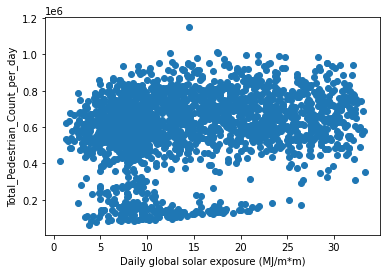

--------------------------------------------------------------------------------------------------------------


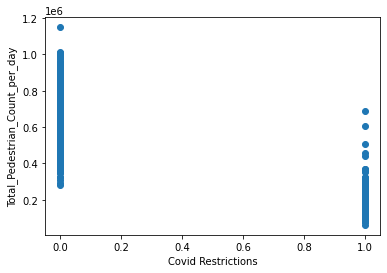

--------------------------------------------------------------------------------------------------------------


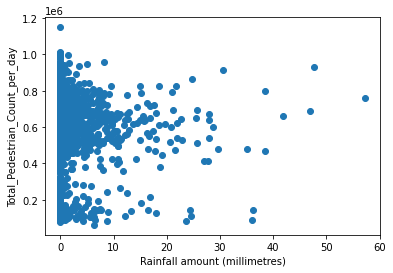

--------------------------------------------------------------------------------------------------------------


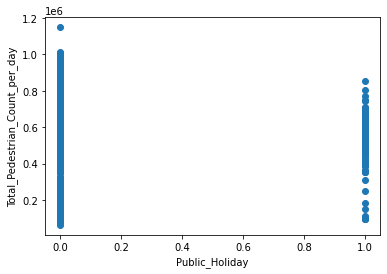

--------------------------------------------------------------------------------------------------------------


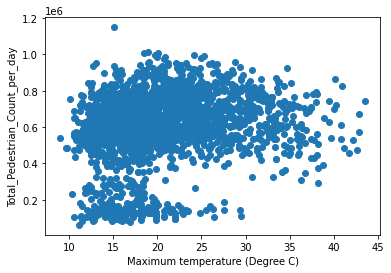

--------------------------------------------------------------------------------------------------------------


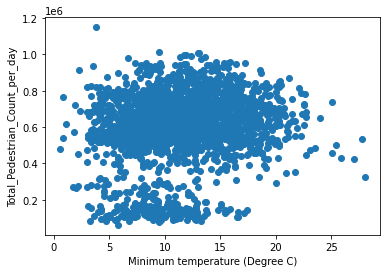

--------------------------------------------------------------------------------------------------------------


In [82]:
# Feature relationship with target
for feature in feat_cols:
  if df[feature].dtypes in ['int','float']:
    plt.clf()
    plt.scatter(df[feature],df[target_col])
    plt.ylabel(target_col)
    plt.xlabel(feature)
    plt.show()
    print('--------------------------------------------------------------------------------------------------------------')

In [83]:
# adding date component
print(df[date_cols])

      day_of_week  monthly_index  year  day_of_year
0     4            1              2015  1          
1     5            1              2015  2          
2     6            1              2015  3          
3     7            1              2015  4          
4     1            1              2015  5          
...  ..           ..               ... ..          
2127  2            10             2020  301        
2128  3            10             2020  302        
2129  4            10             2020  303        
2130  5            10             2020  304        
2131  6            10             2020  305        

[2132 rows x 4 columns]


In [85]:
# get date time format
df['Date'] = df.apply(lambda row:datetime.strptime('{}-{}'.format(int(row['year']), int(row['day_of_year'])), "%Y-%j").strftime("%m-%d-%Y"), axis=1)

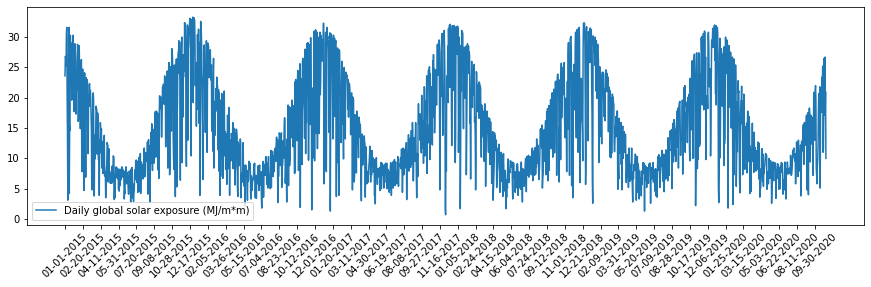

--------------------------------------------------------------------------------------------------------------


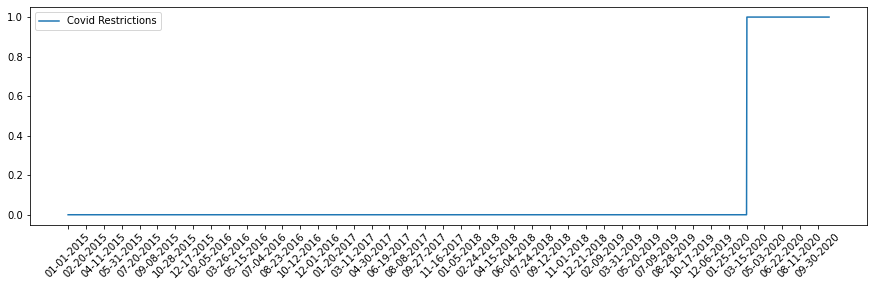

--------------------------------------------------------------------------------------------------------------


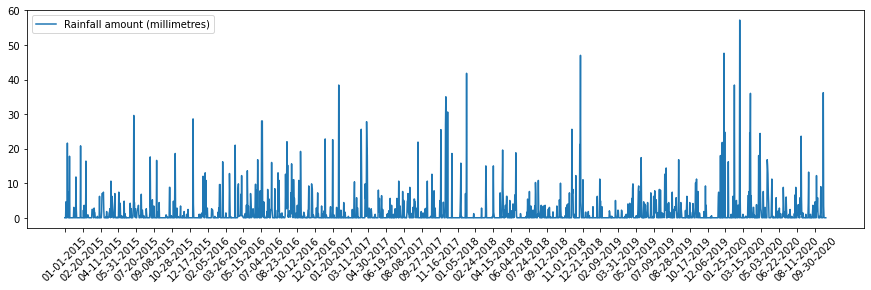

--------------------------------------------------------------------------------------------------------------


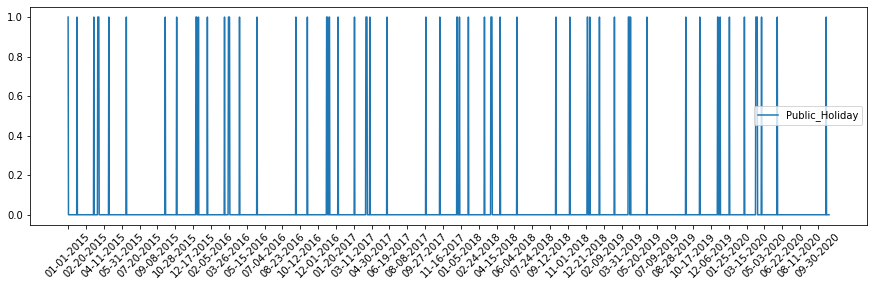

--------------------------------------------------------------------------------------------------------------


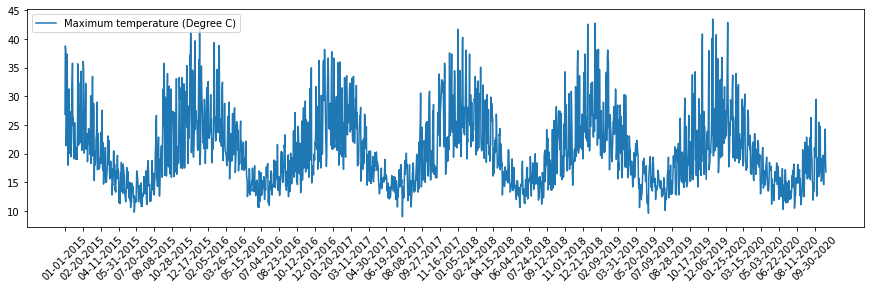

--------------------------------------------------------------------------------------------------------------


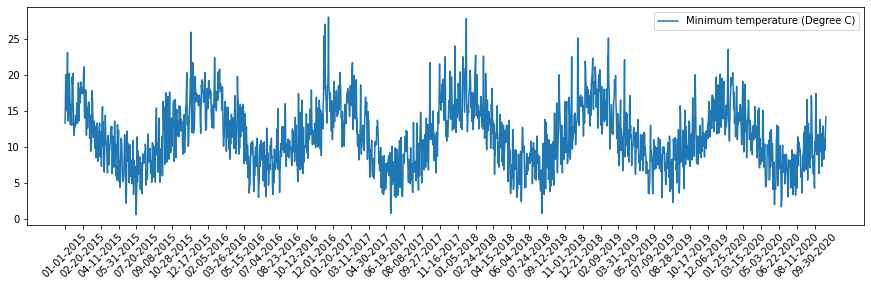

--------------------------------------------------------------------------------------------------------------


In [86]:
num_rows = len(df)
for feature in feat_cols:
  plt.figure(figsize = (15,4))
  plt.plot(range(num_rows), df[feature], label=feature)
  plt.xticks(range(0,num_rows,50),df['Date'].loc[::50],rotation=45)
  plt.legend()
  plt.show()
  print('--------------------------------------------------------------------------------------------------------------')

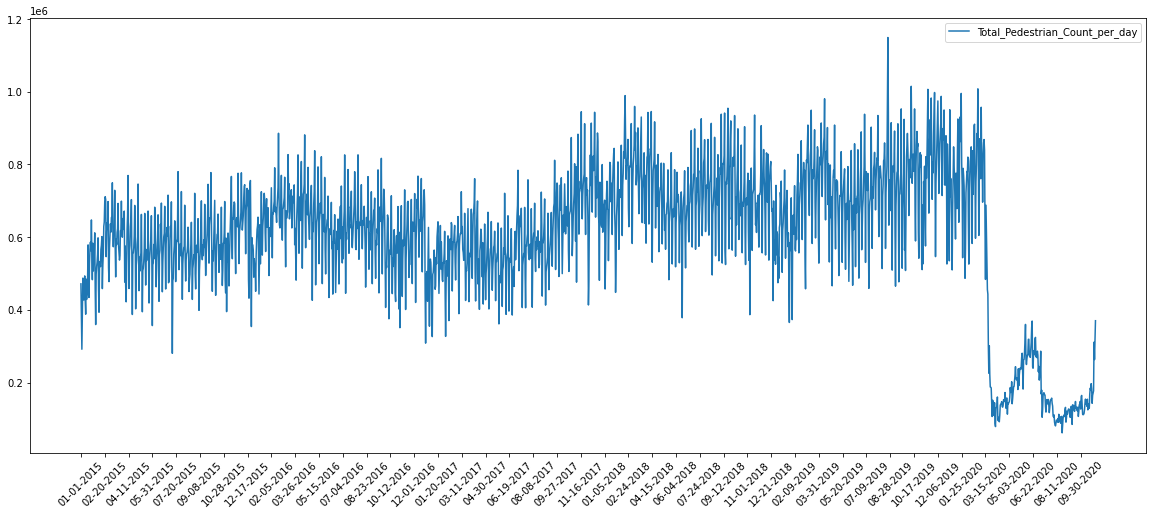

In [89]:
plt.figure(figsize = (20,8))
plt.plot(range(len(df)), df[[target_col]], label=target_col)
plt.legend()
plt.xticks(range(0,num_rows,50),df['Date'].loc[::50],rotation=45)
plt.show()

In [90]:
df

,day_of_week,monthly_index,year,day_of_year,Covid Restrictions,Public_Holiday,Rainfall amount (millimetres),Minimum temperature (Degree C),Maximum temperature (Degree C),Daily global solar exposure (MJ/m*m),Total_Pedestrian_Count_per_day,Date
0,4,1,2015,1,0,1,0.0,13.3,26.9,23.6,471563,01-01-2015
1,5,1,2015,2,0,0,0.0,15.4,38.8,26.8,389048,01-02-2015
2,6,1,2015,3,0,0,0.0,20.0,38.2,26.5,291761,01-03-2015
3,7,1,2015,4,0,0,4.6,16.3,21.4,25.2,382364,01-04-2015
4,1,1,2015,5,0,0,0.0,15.0,22.0,30.7,487220,01-05-2015
...,...,...,...,...,...,...,...,...,...,...,...,...
2127,2,10,2020,301,1,0,0.0,11.1,19.6,20.1,177267,10-27-2020
2128,3,10,2020,302,1,0,0.0,9.5,20.9,26.7,311278,10-28-2020
2129,4,10,2020,303,1,0,0.0,11.2,24.3,17.1,263334,10-29-2020
2130,5,10,2020,304,1,0,0.0,12.9,18.6,21.0,313225,10-30-2020


In [91]:
# Feature selection
from sklearn.feature_selection import SelectKBest, chi2

TOP_N_FEATURES = 5

feat_cols_for_selection = list(set(df.columns.tolist()[:-2]))
chi2_selector = SelectKBest(chi2, k=TOP_N_FEATURES)
features_kbest = chi2_selector.fit(df[feat_cols_for_selection], df[target_col])

In [92]:
from itertools import compress
# top features selected based on CHI2
print('Top-{} features based on chi-squared selection:'.format(TOP_N_FEATURES))
print(list(compress(feat_cols_for_selection, features_kbest.get_support())))

Top-5 features based on chi-squared selection:
['Daily global solar exposure (MJ/m*m)', 'Rainfall amount (millimetres)', 'monthly_index', 'Maximum temperature (Degree C)', 'day_of_year']


In [95]:
output_columns = ['Date']+feat_cols+[target_col]
df[output_columns].to_csv('for_time_series_forceasting_pedestrian_count.tsv', index=False, sep='\t')